# Parameterized WFIRST pupil (varying strut thickness, central obs)

In [19]:
import numpy as np
import skimage.transform
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import os
import glob
import PIL.ImageDraw
import PIL.Image

%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest' 
matplotlib.rcParams['image.cmap'] = 'gray'

Populating the interactive namespace from numpy and matplotlib


In [20]:
telap_dir = os.path.normpath('/astro/opticslab1/SCDA/Apertures/JPL/wfirst')
os.listdir(telap_dir)

['AFTA_CGI_C5_Pupil_onax_1000px.fits', '._AFTA_CGI_C5_Pupil_onax_1000px.fits']

In [21]:
#new_telap_dir = os.path.normpath("/astro/opticslab1/SCDA/Apertures/InputMasks/TelAp")
new_telap_dir = os.path.expanduser("~/Box Sync/scda/InputMasks_wfirst/TelAp")
if not os.path.exists(new_telap_dir):
    os.mkdir(new_telap_dir)
    print("created {:s} for binned aperture arrays".format(new_telap_dir))
else:
    print("Destination {:s} already exists".format(new_telap_dir))

Destination /Users/ntz/Box Sync/scda/InputMasks_wfirst/TelAp already exists


## Set basic parameters

In [99]:
overwrite = True
prim_key = "wfirst"
centobs = True
#D = 1000
D = 1024
N = 128 # quadrant width after binning
symm = 'half' # set to either 'quart' or 'half'
cobs_diam = 31 # integer central obscuration parameter in range [0, 99]; nominal WFIRST value 31
sthick = 26 # integer strut thickness parameter in range [0, 99]; nominal WFIRST value 26

In [83]:
wfirst_ref_telap = fits.getdata(os.path.join(telap_dir, 'AFTA_CGI_C5_Pupil_onax_1000px.fits'))

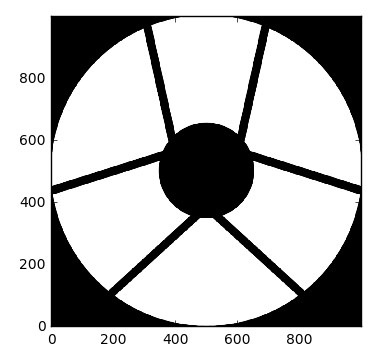

In [84]:
plt.imshow(wfirst_ref_telap)

### Define circular aperture with central obscuration matching WFIRST

In [85]:
inD = float(cobs_diam)/100
outD = 1.
xs = np.linspace(-D/2 + 0.5, D/2 - 0.5, D)
[Xs, Ys] = np.meshgrid(xs, xs)
inside_ann = np.less_equal(Xs**2 + Ys**2, (inD*D/2)**2)
outside_ann = np.greater_equal(Xs**2 + Ys**2, (outD*D/2)**2)
wfirst_nostrut = np.ones((D,D))
wfirst_nostrut[inside_ann] = 0.
wfirst_nostrut[outside_ann] = 0.

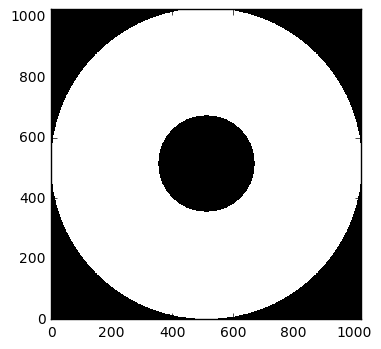

In [86]:
plt.imshow(wfirst_nostrut)

In [87]:
if D == 1000:
    plt.imshow(wfirst_nostrut - wfirst_ref_telap)

In [88]:
xcent = D/2-0.5; ycent = D/2-0.5

#xycent_01 = (xcent + 75.2, ycent + 0.)
#strut_01 = matplotlib.patches.Rectangle(xycent_01, 25.90*D/1000., D, angle=-12.418)
xycent_01 = (xcent + 75.0, ycent + 0.)
strut_01 = matplotlib.patches.Rectangle(xycent_01, float(sthick)*D/1000., D, angle=-12.418)
strut_verts_01 = strut_01.get_verts()

#xycent_02 = (xcent, ycent + 107.7)
#strut_02 = matplotlib.patches.Rectangle(xycent_02, 26.4*D/1000., D, angle=-107.6)
xycent_02 = (xcent, ycent + 107.7)
strut_02 = matplotlib.patches.Rectangle(xycent_02, float(sthick)*D/1000., D, angle=-107.6)
strut_verts_02 = strut_02.get_verts()

#xycent_03 = (xcent, ycent - 97.6)
#strut_03 = matplotlib.patches.Rectangle(xycent_03, 25.95*D/1000., D, angle=-132.4)
xycent_03 = (xcent, ycent - 97.6)
strut_03 = matplotlib.patches.Rectangle(xycent_03, float(sthick)*D/1000., D, angle=-132.4)
strut_verts_03 = strut_03.get_verts()

strut_img = PIL.Image.new('L', (D,D), 1)
PIL.ImageDraw.Draw(strut_img).polygon(list(strut_verts_01.ravel()), outline=0, fill=0)
PIL.ImageDraw.Draw(strut_img).polygon(list(strut_verts_02.ravel()), outline=0, fill=0)
PIL.ImageDraw.Draw(strut_img).polygon(list(strut_verts_03.ravel()), outline=0, fill=0)
strut_mask = np.round(np.array(strut_img))

In [89]:
if D == 1000:
    plt.figure(figsize=(20,20))
    plt.imshow(wfirst_ref_telap-strut_mask, vmin=-1., vmax=1.)
    plt.axis('off')
    #plt.colorbar(orientation='horizontal')

In [90]:
if sthick > 0:
    wfirst_par_pupil = strut_mask*strut_mask[:,::-1]*wfirst_nostrut
else:
    wfirst_par_pupil = wfirst_nostrut

In [91]:
#plt.figure(figsize=(20,20))
#plt.imshow(wfirst_par_pupil)

## Downsample to scale of optimization

In [92]:
N_orig = D/2
scalefac = int(N_orig/N)
print("Binning the original aperture array {0:d}x".format(scalefac))
wfirst_par_pupil_bin = np.reshape(wfirst_par_pupil, (D/scalefac, scalefac, 
                                                     D/scalefac, scalefac)).mean(1).mean(2)

Binning the original aperture array 4x


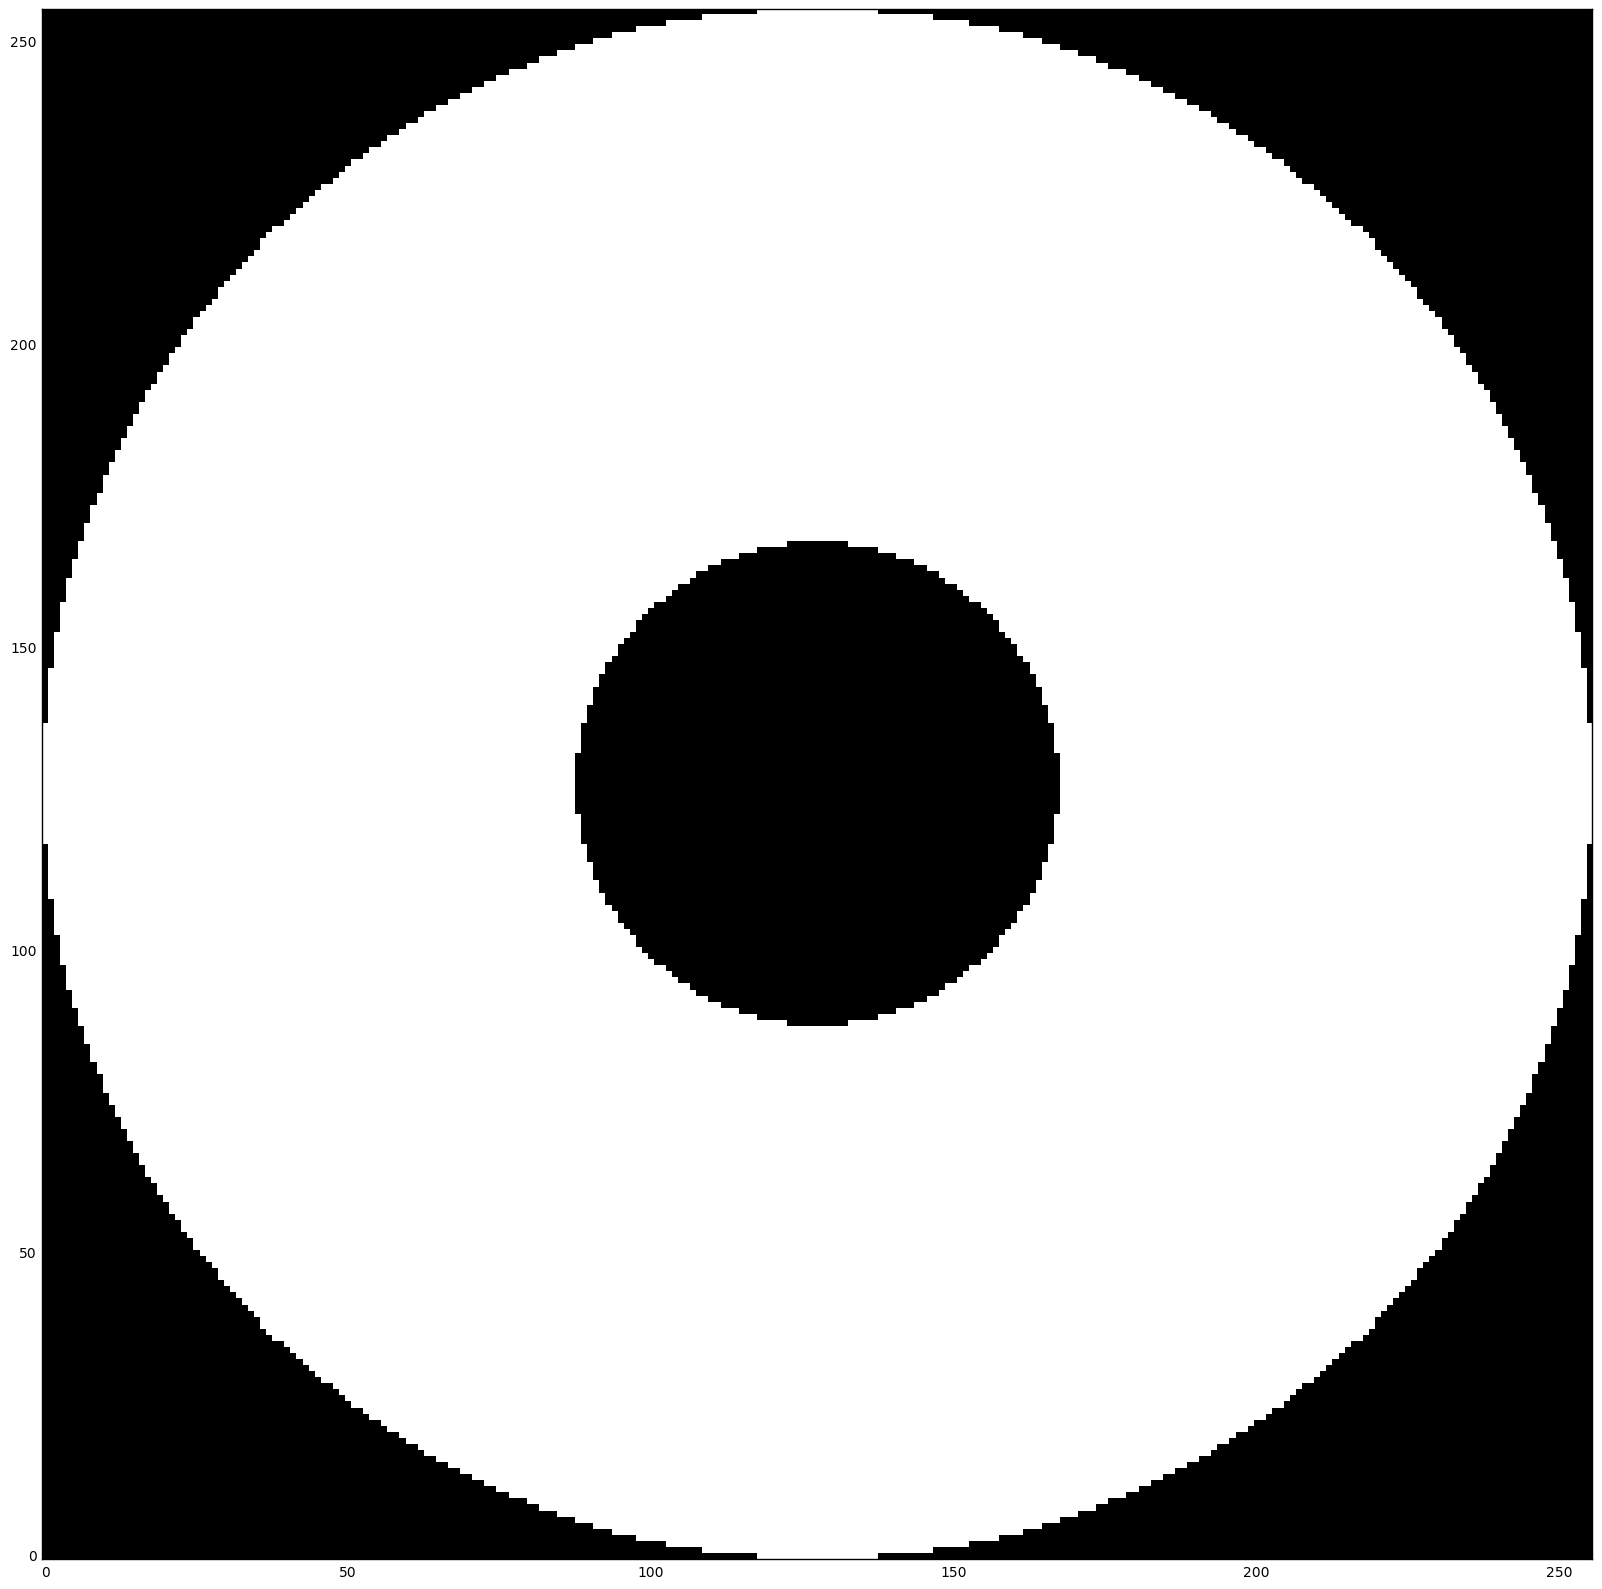

In [93]:
plt.figure(figsize=(20,20))
plt.imshow(np.round(wfirst_par_pupil_bin))

## Crop to right half

In [94]:
wfirst_par_pupil_bin_crop = wfirst_par_pupil_bin[:, N:]
print(wfirst_par_pupil_bin_crop.shape)

(256, 128)


## Form new file name and write 

In [95]:
telap_bin_dat_fname_tail = "TelAp_half_wfirstCobs{0:02d}sthick{1:03d}_N{2:04d}.dat".format(cobs_diam, 10*sthick, N)
telap_bin_dat_fname = os.path.join(new_telap_dir, telap_bin_dat_fname_tail)

In [96]:
if not os.path.exists(telap_bin_dat_fname) or overwrite is True:
    np.savetxt(telap_bin_dat_fname, wfirst_par_pupil_bin_crop, fmt='%.6f', delimiter=" ")
    print("Wrote binned, cropped telescope aperture array to {0:s}".format(telap_bin_dat_fname))
else:
    print("Telescope aperture array {0:s} already exists, will not overwrite".format(telap_bin_dat_fname))

Wrote binned, cropped telescope aperture array to /Users/ntz/Box Sync/scda/InputMasks_wfirst/TelAp/TelAp_half_wfirstCobs31sthick000_N0128.dat


In [97]:
os.listdir(new_telap_dir)

['TelAp_half_wfirstCobs31sthick000_N0125.dat',
 'TelAp_half_wfirstCobs31sthick000_N0128.dat',
 'TelAp_half_wfirstCobs31sthick000_N0250.dat',
 'TelAp_half_wfirstCobs31sthick130_N0125.dat',
 'TelAp_half_wfirstCobs31sthick130_N0128.dat',
 'TelAp_half_wfirstCobs31sthick130_N0250.dat',
 'TelAp_half_wfirstCobs31sthick200_N0125.dat',
 'TelAp_half_wfirstCobs31sthick200_N0128.dat',
 'TelAp_half_wfirstCobs31sthick200_N0250.dat',
 'TelAp_half_wfirstCobs31sthick260_N0125.dat',
 'TelAp_half_wfirstCobs31sthick260_N0128.dat',
 'TelAp_half_wfirstCobs31sthick260_N0250.dat']

In [98]:
#os.remove(os.path.join(new_telap_dir, 'TelAp_half_wfirstCobs31sthick00_N0125.dat'))